# Student Name:

# Preface

Consider the following Environment and Agent classes. 

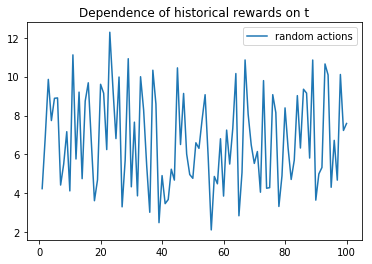

In [14]:
import random
from matplotlib import pyplot as plt 
import numpy as np

class Environment:
    def __init__(self):
        self.time = 1

    def admissible_actions(self):
        return list(range(1,5))

    def get_reward(self, action):
        self.time += 1
        q_star = 2*action+2
        return random.gauss(q_star,1)


class Agent:
    def __init__(self):
        self.current_reward = 0.0

    def step(self, env):
        actions = env.admissible_actions()
        reward = env.get_reward(random.choice(actions))
        self.current_reward = reward
        
        
def rewards_hist(T = 10):
    env = Environment()
    agent = Agent()
    rewards = []
    while env.time <= T:
        agent.step(env)
        rewards.append(agent.current_reward)
    return np.asarray(rewards)


from matplotlib import pyplot as plt 
import numpy as np   
T = 100
plt.plot(range(1,T+1),rewards_hist(T),label='random actions')
plt.title('Dependence of historical rewards on t')
plt.legend()
plt.show()

## Problem 1 (15 points)

Notice that the agent currently selects actions randomly. Please implement the Gradient Bandit Algorithm with $\alpha$ = 0.4. Initialize the numerical preference at 0 for all actions. Run the algorithm 500 times (i.e. for 500 epochs) for T = 1000 and compute the observed average reward for each time t. Plot the average reward from those 500 epochs for 1, 2,..., T.

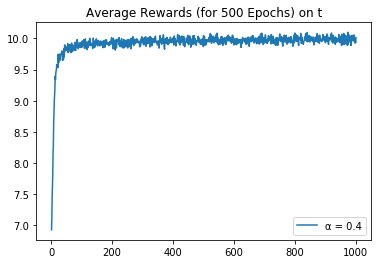

In [38]:
import random
from matplotlib import pyplot as plt 
import numpy as np
from collections import defaultdict

class Environment:
    def __init__(self):
        self.time = 1

    def admissible_actions(self):
        return list(range(1,5))

    def get_reward(self, action):
        self.time += 1
        q_star = 2*action+2
        return random.gauss(q_star,1)


class Agent:
    def __init__(self, alpha = 0.4):
        self.current_reward = 0.0
        self.alpha = alpha
        self.pref = defaultdict(float) # preference dictionary, default preference is 0
        self.pi = {}                   # probablistic policy dictionary
        self.k = 0                     # number of steps taken
        self.baseline = 0.0            # average rewards received
        
    def new_policy(self, all_actions):
        preference_exp_sum = 0
        for action in all_actions:
            preference = self.pref[action]
            preference_exp_sum += np.exp(preference)
        for action in all_actions:
            preference = self.pref[action]
            self.pi[action] = np.exp(preference)/preference_exp_sum
        return

    def step(self, env):
        actions = env.admissible_actions()
        if not self.pi:
            self.new_policy(actions)
        else:
            #assert set(actions) == {key for key in self.pi.keys()}, "policy incoporate all actions and all actions only"
            #assert sum(self.pi.values()) == 1, "policy must be complete (there might be rounding error for {})".format(sum(self.pi.values()))
            pass

        # select action by policy
        selected_action = np.random.choice(
            actions,
            p = [self.pi[a] for a in actions]
        )

        # get rewards
        reward = env.get_reward(selected_action)

        # update rewards
        self.current_reward = reward
        
        # update k and average rewards
        prev_sum = self.baseline * self.k
        self.k += 1
        self.baseline = (prev_sum + reward)/self.k

        # update preferences
        for action in actions:
            if action != selected_action:
                self.pref[action] -= self.alpha*(reward - self.baseline)*self.pi[action]
            else:
                self.pref[action] += self.alpha*(reward - self.baseline)*(1-self.pi[action])
        # update policy
        self.new_policy(actions)

        return



def rewards_hist(T = 10):
    env = Environment()
    agent = Agent()
    rewards = []
    while env.time <= T:
        agent.step(env)
        rewards.append(agent.current_reward)
    return np.asarray(rewards)


def average_rewards_hist(T = 10, eps = 2):
    # initiate a (eps x t) matrix
    rewards = np.empty([eps, T])

    for ep in range(eps):
        env = Environment()
        agent = Agent()

        t = 0
        while env.time <= T:
            agent.step(env)
            rewards[ep][t] = agent.current_reward
            t += 1
    return np.mean(rewards, axis=0) # average over column

from matplotlib import pyplot as plt
import numpy as np   
T = 1000
eps = 500
plt.plot(range(1,T+1), average_rewards_hist(T, eps), label= 'α = 0.4')
plt.title('Average Rewards (for {} Epochs) on t'.format(eps))
plt.legend()
plt.show()

## Problem 2 (10 points)

Add "state" attribute to the Environment which takes values 1 and 2. Assume that the agent still can take actions 1 through 4 in both states. If state=1, the agent gets rewards as in Problem 1, but in state 2 the Environment generates rewards with means -10, -8, -6, and -4 for actions 1, 2, 3, and 4, respectively (assume unit variance as before). Further, assume the Environment can change its state only if the agent selects action 1, and the probability of the switch is 0.05, that is:

$P(New State = 1|Old State = 2, action = 1)=0.05$,
$P(New State = 2|Old State = 2, action = 1)=0.95$,
$P(New State = 2|Old State = 1, action = 1)=0.05$,
$P(New State = 1|Old State = 1, action = 1)=0.95$.

All other transition probabilities are 0.      

Please modify the Gradient Bandit Algorithm you developed in Problem 1 so that numerical preference and policy is state-specific now, i.e. you need to keep track of observations in each state separately. Plot results and discuss your observations. Does the Gradient Bandit Algorithm appear to be appropriate in the case of Markov Decision Process (MDP)? Explain.


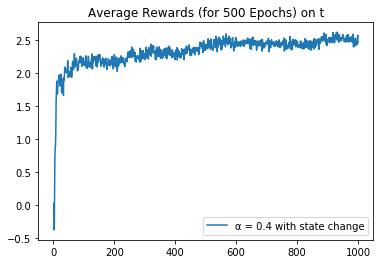

In [31]:
import random
from matplotlib import pyplot as plt 
import numpy as np
from collections import defaultdict

class Environment:
    def __init__(self):
        self.time = 1
        self.state = randint(1,2)

    def admissible_actions(self):
        return list(range(1,5))

    def get_reward(self, action):
        self.time += 1

        # determine reward by state
        if self.state == 1:
            q_star = 2*action+2
        elif self.state == 2:
            q_star = 2*action-12
        else:
            raise ValueError("state must be 1 or 2")

        # 0.05 chance of switching state when action is 1
        if action == 1:
            switch = random.randint(0,1)
            if switch <= 0.05:
                self.state = (self.state % 2) + 1
            else: # remain in current state
                pass

        return random.gauss(q_star,1)


class Agent:
    def __init__(self, alpha = 0.4):
        self.current_reward = 0.0
        self.alpha = alpha
        self.states = {}

    def step(self, env):
        state_index = env.state
        if env.state not in self.states.keys():
            self.states[state_index] = State()

        self.states[state_index].step(env, self.alpha)
        self.current_reward = self.states[state_index].current_reward


class State:
    def __init__(self):
        self.pref = defaultdict(float) # preference dictionary, default preference is 0
        self.pi = {}                   # probablistic policy dictionary
        self.k = 0                     # number of steps taken
        self.baseline = 0.0            # average rewards received

    def new_policy(self, all_actions):
        preference_exp_sum = 0
        for action in all_actions:
            preference = self.pref[action]
            preference_exp_sum += np.exp(preference)
        for action in all_actions:
            preference = self.pref[action]
            self.pi[action] = np.exp(preference)/preference_exp_sum
        return

    def step(self, env, alpha):
        actions = env.admissible_actions()
        if not self.pi:
            self.new_policy(actions)
        else:
            #assert set(actions) == {key for key in self.pi.keys()}, "policy incoporate all actions and all actions only"
            #assert sum(self.pi.values()) == 1, "policy must be complete (there might be rounding error for {})".format(sum(self.pi.values()))
            pass

        # select action by policy
        selected_action = np.random.choice(
            actions,
            p = [self.pi[a] for a in actions]
        )

        # get rewards
        reward = env.get_reward(selected_action)

        # update rewards
        self.current_reward = reward
        
        # update k and average rewards
        prev_sum = self.baseline * self.k
        self.k += 1
        self.baseline = (prev_sum + reward)/self.k

        # update preferences
        for action in actions:
            if action != selected_action:
                self.pref[action] -= alpha*(reward - self.baseline)*self.pi[action]
            else:
                self.pref[action] += alpha*(reward - self.baseline)*(1-self.pi[action])
        # update policy
        self.new_policy(actions)

        return


def rewards_hist(T = 10):
    env = Environment()
    agent = Agent()
    rewards = []
    while env.time <= T:
        agent.step(env)
        rewards.append(agent.current_reward)
    return np.asarray(rewards)


def average_rewards_hist(T = 10, eps = 2):
    # initiate a (eps x t) matrix
    rewards = np.empty([eps, T])

    for ep in range(eps):
        env = Environment()
        agent = Agent()

        t = 0
        while env.time <= T:
            agent.step(env)
            rewards[ep][t] = agent.current_reward
            t += 1
    return np.mean(rewards, axis=0) # average over column

from matplotlib import pyplot as plt
import numpy as np   
T = 1000
eps = 500
plt.plot(range(1,T+1), average_rewards_hist(T, eps), label= 'α = 0.4 with state change')
plt.title('Average Rewards (for {} Epochs) on t'.format(eps))
plt.legend()
plt.show()

### Does the Gradient Bandit Algorithm appear to be appropriate in the case of Markov Decision Process (MDP)? Explain.

The gradient bandit algorithm does not consider the future effect of state change. It approaches the DMP problem with a greedy approach that only considers maximise the rewards of the present state (not future state). Without planning ahead, this greedy approach will likely generate policy that end up traversing through undesirable states that will reduce rewards in the long run.

In [20]:
from random import randint
randint(1,2)

1